# Основы глубинного обучения, майнор ИАД

## Домашнее задание 1. Введение в PyTorch. Полносвязные нейронные сети.

### Общая информация

Дата выдачи: 01.10.2023

Мягкий дедлайн: 23:59MSK 15.10.2023

Жесткий дедлайн: 23:59MSK 20.10.2023

### Оценивание и штрафы
Максимально допустимая оценка за работу — 10 баллов. За каждый день просрочки снимается 1 балл. Сдавать задание после жёсткого дедлайна сдачи нельзя.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов. Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.
Также оценка может быть снижена за плохо читаемый код и плохо оформленные графики. Все ответы должны сопровождаться кодом или комментариями о том, как они были получены.

Итогова оценка считается как
$$
min(task_1, task_2)*0.8 + max(task_1, task_2)*0.2
$$

где task_1 и task_2 - оценки за первое и второе заданиее соответсвенно.
Также, за домашнее задание выставляется 0, если не сделано нулевое или третье задание.
### О задании

В этом задании вам предстоит предсказывать год выпуска песни (**задача регрессии**) по некоторым звуковым признакам: [данные](https://archive.ics.uci.edu/ml/datasets/yearpredictionmsd). В ячейках ниже находится код для загрузки данных. Обратите внимание, что обучающая и тестовая выборки располагаются в одном файле, поэтому НЕ меняйте ячейку, в которой производится деление данных.

In [1]:
import torch
from torch import nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
import random
device = "cuda" if torch.cuda.is_available() else "cpu"
from tqdm.notebook import tqdm
from IPython.display import clear_output
import matplotlib.pyplot as plt

In [2]:
!wget -O data.txt.zip https://archive.ics.uci.edu/ml/machine-learning-databases/00203/YearPredictionMSD.txt.zip

--2023-10-15 07:34:36--  https://archive.ics.uci.edu/ml/machine-learning-databases/00203/YearPredictionMSD.txt.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘data.txt.zip’

data.txt.zip            [      <=>           ] 201.24M  25.6MB/s    in 9.1s    

2023-10-15 07:34:46 (22.1 MB/s) - ‘data.txt.zip’ saved [211011981]



In [3]:
df = pd.read_csv('data.txt.zip', header=None)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,81,82,83,84,85,86,87,88,89,90
0,2001,49.94357,21.47114,73.07750,8.74861,-17.40628,-13.09905,-25.01202,-12.23257,7.83089,...,13.01620,-54.40548,58.99367,15.37344,1.11144,-23.08793,68.40795,-1.82223,-27.46348,2.26327
1,2001,48.73215,18.42930,70.32679,12.94636,-10.32437,-24.83777,8.76630,-0.92019,18.76548,...,5.66812,-19.68073,33.04964,42.87836,-9.90378,-32.22788,70.49388,12.04941,58.43453,26.92061
2,2001,50.95714,31.85602,55.81851,13.41693,-6.57898,-18.54940,-3.27872,-2.35035,16.07017,...,3.03800,26.05866,-50.92779,10.93792,-0.07568,43.20130,-115.00698,-0.05859,39.67068,-0.66345
3,2001,48.24750,-1.89837,36.29772,2.58776,0.97170,-26.21683,5.05097,-10.34124,3.55005,...,34.57337,-171.70734,-16.96705,-46.67617,-12.51516,82.58061,-72.08993,9.90558,199.62971,18.85382
4,2001,50.97020,42.20998,67.09964,8.46791,-15.85279,-16.81409,-12.48207,-9.37636,12.63699,...,9.92661,-55.95724,64.92712,-17.72522,-1.49237,-7.50035,51.76631,7.88713,55.66926,28.74903


Мы вывели кусок данных, чтобы понять, насколько они пригодны для работы без изменений. Здесь ясно, что сомнительно дальше с такими данными работать, потому что как минимум есть отрицательные значения, которые не отмасштабированы, кроме того еще сразу бросается в глаза совсем разная размерность, где-то видим реально большие числа, а где-то 0.075. Ясно, что будем скейлить.

In [4]:
X = df.iloc[:, 1:].values
y = df.iloc[:, 0].values

train_size = 463715
X_train = X[:train_size, :]
y_train = y[:train_size]
X_test = X[train_size:, :]
y_test = y[train_size:]

## Задание 0. (0 баллов, но при невыполнении максимум за все задание &mdash; 0 баллов)

Мы будем использовать RMSE как метрику качества. Для самого первого бейзлайна обучите `Ridge` регрессию из `sklearn`. Кроме того, посчитайте качество при наилучшем константном прогнозе.

Для выполнения данного задания (и всех последующих) предобработайте данные.

1. Зафиксируйте random_seed везде где только возможно. Вам предоставлена функция для этого, однако вы можете дополнить ее своими дополнениями
2. Обучите StandertScaler и предобработайте ваши данные. В следующих заданиях можете использовать другой scaler или вообще отказаться от него


In [5]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

In [6]:
def set_random_seed(seed):
    torch.backends.cudnn.deterministic = True
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    # Add smth here if you need...

In [7]:
set_random_seed(42)

In [8]:
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [9]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error as MSE

In [10]:
model = Ridge()
model.fit(X_train, y_train)
rmse_for_model = MSE(y_test, model.predict(X_test), squared = False)

rmse_for_model

9.510160820470436

Лучшая константа для RMSE это среднее, посчитаем значение метрики при нем

In [11]:
best_rmse_metric = MSE(y_test, [np.mean(y_train)] * len(y_test), squared = False)

best_rmse_metric

10.85246390513634

## Задание 1. (максимум 10 баллов)

Закрепите свои знания о том, как pytorch работает с обратным распространением ошибки, проделав следующие шаги:

1. Создайте модель линейной регрессии, которая будет состоять только из одного Linear слоя.
2. Напишите цикл обучения вашей линейной регрессии. В нем реализуйте подсчет функции потерь, сделайте шаг градиентного спуска. Запрещено использовать готовые оптимизаторы и loss-функции из библиотеки pytorch. Для подсчета градиента воспользуйтесь методом backward.
3. Запустите обучение на 10 эпохах, после каждой проверяйте значение целевой метрики на тестовой выборке.
4. Выведите на экран графики метрики и значения функции потерь на тестовой и обучающей выборке.

В данном задании нет цели побить какой-то порог по метрике. Ваша задача - убедиться в том, что ваш рукописный цикл обучения работает. Для ускорения вычислений и обучения модели можете брать только срез данных, а не весь датасет.

Возьмем в качестве loss-функции RMSE, а в качестве метрики - MAE

In [12]:
def RMSE(y_true, y_pred):
    return torch.sqrt(torch.mean( (y_true - y_pred ) ** 2))

In [13]:
def MAE(y_true, y_pred):
    return torch.mean( torch.abs((y_true - y_pred )) )

In [14]:
X_train_slice = torch.tensor(X_train[:10000], dtype=torch.float32)
X_test_slice = torch.tensor(X_test[:10000], dtype=torch.float32)
y_train_slice = torch.tensor(y_train[:10000], dtype=torch.float32)
y_test_slice = torch.tensor(y_test[:10000], dtype=torch.float32)

In [38]:
def train(lr=0.05, n_epochs=10):
    set_random_seed(42) # чтобы каждый раз модель создавалась с одними и теми же весами
    model = nn.Sequential(nn.Linear(X_train.shape[1], 1))
    loss_train = []
    loss_test = []
    metric_train = []
    metric_test = []

    for epoch in range(n_epochs):
        y_pred = model(X_train_slice)
        temp_loss_train = RMSE(y_train_slice, y_pred)
        loss_train.append(temp_loss_train.detach().numpy())
        temp_loss_train.backward()
        for param in model.parameters():
            param.data -= lr * param.grad
            param.grad.data.zero_()

        with torch.no_grad():
            temp_metric_train = MAE(y_train_slice, y_pred)
            metric_train.append(temp_metric_train)

            y_pred = model(X_test_slice)
            temp_loss_test = RMSE(y_test_slice, y_pred)
            loss_test.append(temp_loss_test)
            temp_metric_test = MAE(y_test_slice, y_pred)
            metric_test.append(temp_metric_test)
        print(f'эпоха №{epoch + 1}:' + ' ' * (5 if (epoch<9) else 4) +
              f'train RMSE = {temp_loss_train} \n' +
              ' '*14 + f'train MAE  = {temp_metric_train}\n' +
              ' '*14 + f'test RMSE  = {temp_loss_test}\n' +
              ' '*14 + f'test MAE  = {temp_metric_test}\n')


    plt.plot(np.arange(1, n_epochs+1), loss_test, marker='o')
    plt.plot(np.arange(1, n_epochs+1), loss_train, marker='o')
    plt.title('RMSE на train и test')
    plt.legend(['RMSE on test', 'RMSE on train'])
    plt.xticks(np.arange(1, n_epochs+1, 1.0))
    plt.xlabel('№ эпохи')
    plt.ylabel('значение RMSE')
    plt.show()

    plt.plot(np.arange(1, n_epochs+1), metric_test, marker='o')
    plt.plot(np.arange(1, n_epochs+1), metric_train, marker='o')
    plt.legend(['MAE on test', 'MAE on train'])
    plt.title('MAE на train и test')
    plt.xticks(np.arange(1, n_epochs+1, 1.0))
    plt.xlabel('№ эпохи')
    plt.ylabel('значение MAE')
    plt.show()

эпоха №1:     train RMSE = 1998.94482421875 
              train MAE  = 1998.9190673828125
              test RMSE  = 1998.1575927734375
              test MAE  = 1998.1287841796875

эпоха №2:     train RMSE = 1998.8931884765625 
              train MAE  = 1998.8673095703125
              test RMSE  = 1998.107177734375
              test MAE  = 1998.0782470703125

эпоха №3:     train RMSE = 1998.84130859375 
              train MAE  = 1998.8154296875
              test RMSE  = 1998.0567626953125
              test MAE  = 1998.0277099609375

эпоха №4:     train RMSE = 1998.7894287109375 
              train MAE  = 1998.763671875
              test RMSE  = 1998.00634765625
              test MAE  = 1997.977294921875

эпоха №5:     train RMSE = 1998.7376708984375 
              train MAE  = 1998.711669921875
              test RMSE  = 1997.9559326171875
              test MAE  = 1997.9267578125

эпоха №6:     train RMSE = 1998.685791015625 
              train MAE  = 1998.659912109375
   

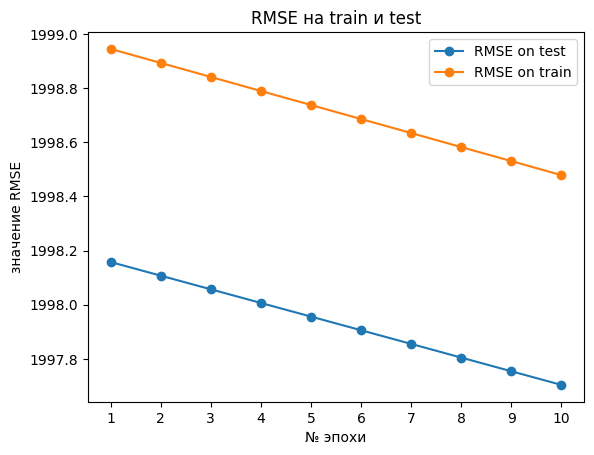

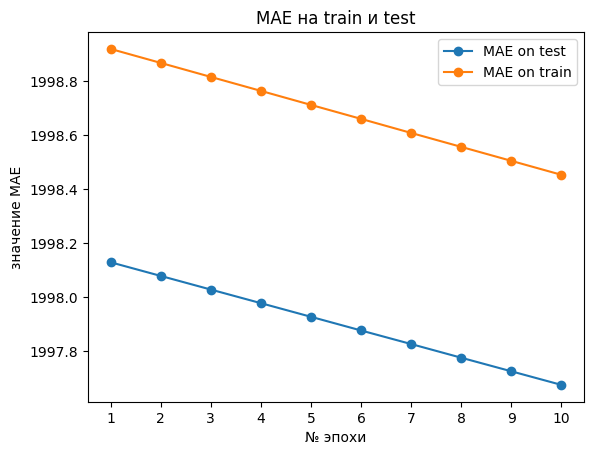

In [39]:
train()

## Задание 2. (максимум 10 баллов)

Реализуйте обучение и тестирование нейронной сети для предоставленного вам набора данных. Соотношение между полученным значением метрики на тестовой выборке и баллами за задание следующее:

- $\text{RMSE} \le 9.00 $ &mdash; 4 балла
- $\text{RMSE} \le 8.90 $ &mdash; 6 баллов
- $\text{RMSE} \le 8.80 $ &mdash; 8 баллов
- $\text{RMSE} \le 8.75 $ &mdash; 10 баллов

Есть несколько правил, которых вам нужно придерживаться:

- Весь пайплайн обучения должен быть написан на PyTorch. При этом вы можете пользоваться другими библиотеками (`numpy`, `sklearn` и пр.), но только для обработки данных. То есть как угодно трансформировать данные и считать метрики с помощью этих библиотек можно, а импортировать модели из `sklearn` и выбивать с их помощью требуемое качество &mdash; нельзя. Также нельзя пользоваться библиотеками, для которых сам PyTorch является зависимостью.

- Мы никак не ограничиваем ваш выбор архитектуры модели, но скорее всего вам будет достаточно полносвязной нейронной сети.

- Для обучения запрещается использовать какие-либо иные данные, кроме обучающей выборки.

- Ансамблирование моделей запрещено.

### Полезные советы:

- Очень вряд ли, что у вас с первого раза получится выбить качество на 10 баллов, поэтому пробуйте разные архитектуры, оптимизаторы и значения гиперпараметров. В идеале при запуске каждого нового эксперимента вы должны менять что-то одно, чтобы точно знать, как этот фактор влияет на качество.

- Не забудьте, что для улучшения качества модели вам поможет **нормировка таргета**.

- Тот факт, что мы занимаемся глубинным обучением, не означает, что стоит забывать про приемы, использующиеся в классическом машинном обучении. Так что обязательно проводите исследовательский анализ данных, отрисовывайте нужные графики и не забывайте про масштабирование и подбор гиперпараметров.

- Вы наверняка столкнетесь с тем, что ваша нейронная сеть будет сильно переобучаться. Для нейросетей существуют специальные методы регуляризации, например, dropout ([статья](https://jmlr.org/papers/volume15/srivastava14a/srivastava14a.pdf)) и weight decay ([блогпост](https://towardsdatascience.com/weight-decay-l2-regularization-90a9e17713cd)). Они, разумеется, реализованы в PyTorch. Попробуйте поэкспериментировать с ними.

- Если вы чего-то не знаете, не гнушайтесь гуглить. В интернете очень много полезной информации, туториалов и советов по глубинному обучению в целом и по PyTorch в частности. Но не забывайте, что за скатанный код без ссылки на источник придется ответить по всей строгости!

- Если вы сразу реализуете обучение на GPU, то у вас будет больше времени на эксперименты, так как любые вычисления будут работать быстрее. Google Colab предоставляет несколько GPU-часов (обычно около 8-10) в сутки бесплатно.

- Чтобы отладить код, можете обучаться на небольшой части данных или даже на одном батче. Если лосс на обучающей выборке не падает, то что-то точно идет не так!

- Пользуйтесь утилитами, которые вам предоставляет PyTorch (например, Dataset и Dataloader). Их специально разработали для упрощения разработки пайплайна обучения.

- Скорее всего вы захотите отслеживать прогресс обучения. Для создания прогресс-баров есть удобная библиотека `tqdm`.

- Быть может, вы захотите, чтобы графики рисовались прямо во время обучения. Можете воспользоваться функцией [clear_output](http://ipython.org/ipython-doc/dev/api/generated/IPython.display.html#IPython.display.clear_output), чтобы удалять старый график и рисовать новый на его месте.

**ОБЯЗАТЕЛЬНО** рисуйте графики зависимости лосса/метрики на обучающей и тестовой выборках в зависимости от времени обучения. Если обучение занимает относительно небольшое число эпох, то лучше рисовать зависимость от номера шага обучения, если же эпох больше, то рисуйте зависимость по эпохам. Если проверяющий не увидит такого графика для вашей лучшей модели, то он в праве снизить баллы за задание.

**ВАЖНО!** Ваше решение должно быть воспроизводимым. Если это не так, то проверяющий имеет право снизить баллы за задание. Чтобы зафиксировать random seed, воспользуйтесь функцией из предыдущего задания.



Вы можете придерживаться любой адекватной струкуры кода, но мы советуем воспользоваться сигнатурами функций, которые приведены ниже. Лучше всего, если вы проверите ваши предсказания ассертом: так вы убережете себя от разных косяков, например, что вектор предсказаний состоит из всего одного числа. В любом случае, внимательно следите за тем, для каких тензоров вы считаете метрику RMSE. При случайном или намеренном введении в заблуждение проверяющие очень сильно разозлятся.

***NB*** требуемый график для лучшей модели привел в 3-м задании

In [17]:
class myDataset(torch.utils.data.Dataset): # по образу и подобию семинара №1 создал свой датасет, чтобы потом его кидать в DataLoader
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx, :], self.y[idx]

В исходных сигнатурах функций train и test хотели, чтобы criterion был из torch.nn, однако там нет класса для RMSE, поэтому я создал свой класс - наследник nn.Module, который реализует RMSE. Код подглядел [здесь](https://discuss.pytorch.org/t/rmse-loss-function/16540/3).

In [18]:
class RMSELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()

    def forward(self, y_true, y_pred):
        return torch.sqrt(self.mse(y_true, y_pred))

### Эксперимент 1

Для начала возьмем простейшую нейронку с 1 линеным слоем и ReLu после него (отрицательные выходы нам не нужны). Эпох 5, batch_size = 128, learning rate = 0.01

In [19]:
def train(model, optimizer, criterion, train_loader):
    """
    params:
        model - torch.nn.Module to be fitted
        optimizer - model optimizer
        criterion - loss function from torch.nn
        train_loader - torch.utils.data.Dataloader with train set
    """

    for x_train, y_train in tqdm(train_loader):
        y_pred = model(x_train.to(device)).reshape(1, -1).squeeze(0)
        loss = criterion(y_pred, y_train.to(device))
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()


def test(model, criterion, test_loader):
    """
    params:
        model - torch.nn.Module to be evaluated on test set
        criterion - loss function from torch.nn
        test_loader - torch.utils.data.Dataloader with test set
    ----------
    returns:
        test_loss - RMSE on test
    """

    val_loss = []
    with torch.no_grad():
        for x_val, y_val in tqdm(test_loader):
            y_pred = model(x_val.to(device)).reshape(1, -1).squeeze(0)
            loss = criterion(y_pred, y_val.to(device))
            val_loss.append(loss.cpu().numpy())
    test_loss = np.sqrt(np.mean(val_loss))

    return test_loss

In [20]:
train_set = myDataset(torch.Tensor(X_train), torch.Tensor(y_train))
train_loader = torch.utils.data.DataLoader(train_set, batch_size=128)

test_set = myDataset(torch.Tensor(X_test), torch.Tensor(y_test))
test_loader = torch.utils.data.DataLoader(test_set, batch_size=128)

set_random_seed(42)
model = nn.Sequential(nn.Linear(X_train.shape[1], 1), nn.ReLU())
model.to(device)

optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

criterion_train = RMSELoss()
criterion_test = nn.MSELoss()

n_epochs = 5

for epoch in range(n_epochs):
    train(model, optimizer, criterion_train, train_loader)
    print(f'Epoch № {epoch+1}: loss = { test(model, criterion_test, test_loader) }')


  0%|          | 0/3623 [00:00<?, ?it/s]

  0%|          | 0/404 [00:00<?, ?it/s]

Epoch № 1: loss = 1937.989990234375


  0%|          | 0/3623 [00:00<?, ?it/s]

  0%|          | 0/404 [00:00<?, ?it/s]

Epoch № 2: loss = 1880.6929931640625


  0%|          | 0/3623 [00:00<?, ?it/s]

  0%|          | 0/404 [00:00<?, ?it/s]

Epoch № 3: loss = 1827.5819091796875


  0%|          | 0/3623 [00:00<?, ?it/s]

  0%|          | 0/404 [00:00<?, ?it/s]

Epoch № 4: loss = 1778.685302734375


  0%|          | 0/3623 [00:00<?, ?it/s]

  0%|          | 0/404 [00:00<?, ?it/s]

Epoch № 5: loss = 1733.972900390625


### Эксперимент 2

Добавим к прошлому эксперименту нормализацию таргета, как советовали в условии

In [21]:
def train(model, optimizer, criterion, train_loader):
    """
    params:
        model - torch.nn.Module to be fitted
        optimizer - model optimizer
        criterion - loss function from torch.nn
        train_loader - torch.utils.data.Dataloader with train set
    """

    for x_train, y_train in tqdm(train_loader):
        y_pred = model(x_train.to(device))
        loss = criterion(y_pred.reshape(1, -1)[0], y_train.reshape(1, -1)[0].to(device))
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

def test(model, criterion, test_loader):
    """
    params:
        model - torch.nn.Module to be evaluated on test set
        criterion - loss function from torch.nn
        test_loader - torch.utils.data.Dataloader with test set
    ----------
    returns:
        test_loss - RMSE on test
    """

    val_loss = []
    with torch.no_grad():
        for x_val, y_val in tqdm(test_loader):
            y_pred = model(x_val.to(device)).cpu()
            loss = criterion(
                torch.Tensor(scaler.inverse_transform(y_pred).reshape(1, -1)[0]).to(device),
                torch.tensor(scaler.inverse_transform(y_val).reshape(1, -1)[0]).to(device))
            val_loss.append(loss.cpu().numpy())
    test_loss = np.sqrt(np.mean(val_loss))

    return test_loss

In [22]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit( y_train.reshape(-1, 1) )
y_train_norm = scaler.transform( y_train.reshape(-1, 1) )
y_test_norm = scaler.transform( y_test.reshape(-1, 1) )

In [23]:
train_set = myDataset(torch.Tensor(X_train), torch.Tensor(y_train_norm))
train_loader = torch.utils.data.DataLoader(train_set, batch_size=128)

test_set = myDataset(torch.Tensor(X_test), torch.Tensor(y_test_norm))
test_loader = torch.utils.data.DataLoader(test_set, batch_size=128)

set_random_seed(42)
model = nn.Sequential(nn.Linear(X_train.shape[1], 1), nn.ReLU())
model.to(device)

optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

criterion_train = RMSELoss()
criterion_test = nn.MSELoss()

n_epochs = 5

for epoch in range(n_epochs):
    train(model, optimizer, criterion_train, train_loader)
    print(f'Epoch № {epoch+1}: loss = { test(model, criterion_test, test_loader) }')


  0%|          | 0/3623 [00:00<?, ?it/s]

  0%|          | 0/404 [00:00<?, ?it/s]

Epoch № 1: loss = 9.991652968700432


  0%|          | 0/3623 [00:00<?, ?it/s]

  0%|          | 0/404 [00:00<?, ?it/s]

Epoch № 2: loss = 9.991652982271374


  0%|          | 0/3623 [00:00<?, ?it/s]

  0%|          | 0/404 [00:00<?, ?it/s]

Epoch № 3: loss = 9.991653071102245


  0%|          | 0/3623 [00:00<?, ?it/s]

  0%|          | 0/404 [00:00<?, ?it/s]

Epoch № 4: loss = 9.991652899612635


  0%|          | 0/3623 [00:00<?, ?it/s]

  0%|          | 0/404 [00:00<?, ?it/s]

Epoch № 5: loss = 9.991653071533337


### Эксперимент 3

Добавим еще 1 линейный слой в надежде, что теорема Цыбенко нас спасет ([здесь](https://yandex.ru/q/machine-learning/10401405953/#:~:text=%D0%9A%D0%BE%D0%BB%D0%B8%D1%87%D0%B5%D1%81%D1%82%D0%B2%D0%BE%20%D1%81%D0%BA%D1%80%D1%8B%D1%82%D1%8B%D1%85%20%D0%BD%D0%B5%D0%B9%D1%80%D0%BE%D0%BD%D0%BE%D0%B2%20%D0%B4%D0%BE%D0%BB%D0%B6%D0%BD%D0%BE%20%D0%B1%D1%8B%D1%82%D1%8C,%D1%80%D0%B0%D0%B7%D0%B0%20%D0%B1%D0%BE%D0%BB%D1%8C%D1%88%D0%B5%20%D1%80%D0%B0%D0%B7%D0%BC%D0%B5%D1%80%D0%B0%20%D0%B2%D1%85%D0%BE%D0%B4%D0%BD%D0%BE%D0%B3%D0%BE%20%D1%81%D0%BB%D0%BE%D1%8F.) нашел инфу о том, сколько стоит попробовать поставить размер 2-го слоя)

In [24]:
train_set = myDataset(torch.Tensor(X_train), torch.Tensor(y_train_norm))
train_loader = torch.utils.data.DataLoader(train_set, batch_size=128)

test_set = myDataset(torch.Tensor(X_test), torch.Tensor(y_test_norm))
test_loader = torch.utils.data.DataLoader(test_set, batch_size=128)

set_random_seed(42)
model = nn.Sequential(nn.Linear(X_train.shape[1], 61), nn.ReLU(), nn.Linear(61, 1), nn.ReLU())
model.to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
criterion_train = RMSELoss()
criterion_test = nn.MSELoss()

n_epochs = 5

for epoch in range(n_epochs):
    train(model, optimizer, criterion_train, train_loader)
    print(f'Epoch № {epoch+1}: loss = { test(model, criterion_test, test_loader) }')

  0%|          | 0/3623 [00:00<?, ?it/s]

  0%|          | 0/404 [00:00<?, ?it/s]

Epoch № 1: loss = 9.674444055617569


  0%|          | 0/3623 [00:00<?, ?it/s]

  0%|          | 0/404 [00:00<?, ?it/s]

Epoch № 2: loss = 9.489622953386801


  0%|          | 0/3623 [00:00<?, ?it/s]

  0%|          | 0/404 [00:00<?, ?it/s]

Epoch № 3: loss = 9.385589513949554


  0%|          | 0/3623 [00:00<?, ?it/s]

  0%|          | 0/404 [00:00<?, ?it/s]

Epoch № 4: loss = 9.326350168326181


  0%|          | 0/3623 [00:00<?, ?it/s]

  0%|          | 0/404 [00:00<?, ?it/s]

Epoch № 5: loss = 9.288271749482497


### Эксперимент 4

Попробуем крутого Adam'а вместо SGD

In [25]:
train_set = myDataset(torch.Tensor(X_train), torch.Tensor(y_train_norm))
train_loader = torch.utils.data.DataLoader(train_set, batch_size=128)

test_set = myDataset(torch.Tensor(X_test), torch.Tensor(y_test_norm))
test_loader = torch.utils.data.DataLoader(test_set, batch_size=128)

set_random_seed(42)
model = nn.Sequential(nn.Linear(X_train.shape[1], 61), nn.ReLU(), nn.Linear(61, 1), nn.ReLU())
model.to(device)
optimizer = torch.optim.Adam(model.parameters())
criterion_train = RMSELoss()
criterion_test = nn.MSELoss()

n_epochs = 5

for epoch in range(n_epochs):
    train(model, optimizer, criterion_train, train_loader)
    print(f'Epoch № {epoch+1}: loss = { test(model, criterion_test, test_loader) }')

  0%|          | 0/3623 [00:00<?, ?it/s]

  0%|          | 0/404 [00:00<?, ?it/s]

Epoch № 1: loss = 9.376925073967438


  0%|          | 0/3623 [00:00<?, ?it/s]

  0%|          | 0/404 [00:00<?, ?it/s]

Epoch № 2: loss = 9.228607553996271


  0%|          | 0/3623 [00:00<?, ?it/s]

  0%|          | 0/404 [00:00<?, ?it/s]

Epoch № 3: loss = 9.124609976482411


  0%|          | 0/3623 [00:00<?, ?it/s]

  0%|          | 0/404 [00:00<?, ?it/s]

Epoch № 4: loss = 9.07759538104178


  0%|          | 0/3623 [00:00<?, ?it/s]

  0%|          | 0/404 [00:00<?, ?it/s]

Epoch № 5: loss = 9.05692484363779


### Эксперимент 5

Побалуемся с количеством линейных слоев в модели

#### 3 слоя

In [26]:
train_set = myDataset(torch.Tensor(X_train), torch.Tensor(y_train_norm))
train_loader = torch.utils.data.DataLoader(train_set, batch_size=128)

test_set = myDataset(torch.Tensor(X_test), torch.Tensor(y_test_norm))
test_loader = torch.utils.data.DataLoader(test_set, batch_size=128)

set_random_seed(42)
model = nn.Sequential(nn.Linear(X_train.shape[1], 61), nn.ReLU(),
                      nn.Linear(61, 42), nn.ReLU(),
                      nn.Linear(42, 1), nn.ReLU())
model.to(device)
optimizer = torch.optim.Adam(model.parameters())
criterion_train = RMSELoss()
criterion_test = nn.MSELoss()

n_epochs = 5

for epoch in range(n_epochs):
    train(model, optimizer, criterion_train, train_loader)
    print(f'Epoch № {epoch+1}: loss = { test(model, criterion_test, test_loader) }')

  0%|          | 0/3623 [00:00<?, ?it/s]

  0%|          | 0/404 [00:00<?, ?it/s]

Epoch № 1: loss = 9.074034525206947


  0%|          | 0/3623 [00:00<?, ?it/s]

  0%|          | 0/404 [00:00<?, ?it/s]

Epoch № 2: loss = 9.017318704729473


  0%|          | 0/3623 [00:00<?, ?it/s]

  0%|          | 0/404 [00:00<?, ?it/s]

Epoch № 3: loss = 8.983625191499838


  0%|          | 0/3623 [00:00<?, ?it/s]

  0%|          | 0/404 [00:00<?, ?it/s]

Epoch № 4: loss = 8.952883343990486


  0%|          | 0/3623 [00:00<?, ?it/s]

  0%|          | 0/404 [00:00<?, ?it/s]

Epoch № 5: loss = 8.943937065731117


#### 4 слоя

In [27]:
train_set = myDataset(torch.Tensor(X_train), torch.Tensor(y_train_norm))
train_loader = torch.utils.data.DataLoader(train_set, batch_size=128)

test_set = myDataset(torch.Tensor(X_test), torch.Tensor(y_test_norm))
test_loader = torch.utils.data.DataLoader(test_set, batch_size=128)

set_random_seed(42)
model = nn.Sequential(nn.Linear(X_train.shape[1], 61), nn.ReLU(),
                      nn.Linear(61, 42), nn.ReLU(),
                      nn.Linear(42, 29), nn.ReLU(),
                      nn.Linear(29, 1), nn.ReLU())
model.to(device)
optimizer = torch.optim.Adam(model.parameters())
criterion_train = RMSELoss()
criterion_test = nn.MSELoss()

n_epochs = 5

for epoch in range(n_epochs):
    train(model, optimizer, criterion_train, train_loader)
    print(f'Epoch № {epoch+1}: loss = { test(model, criterion_test, test_loader) }')

  0%|          | 0/3623 [00:00<?, ?it/s]

  0%|          | 0/404 [00:00<?, ?it/s]

Epoch № 1: loss = 9.075903831304359


  0%|          | 0/3623 [00:00<?, ?it/s]

  0%|          | 0/404 [00:00<?, ?it/s]

Epoch № 2: loss = 8.978913989580866


  0%|          | 0/3623 [00:00<?, ?it/s]

  0%|          | 0/404 [00:00<?, ?it/s]

Epoch № 3: loss = 8.918983332137648


  0%|          | 0/3623 [00:00<?, ?it/s]

  0%|          | 0/404 [00:00<?, ?it/s]

Epoch № 4: loss = 8.884519119026455


  0%|          | 0/3623 [00:00<?, ?it/s]

  0%|          | 0/404 [00:00<?, ?it/s]

Epoch № 5: loss = 8.880255779980228


#### 5 слоев

In [28]:
train_set = myDataset(torch.Tensor(X_train), torch.Tensor(y_train_norm))
train_loader = torch.utils.data.DataLoader(train_set, batch_size=128)

test_set = myDataset(torch.Tensor(X_test), torch.Tensor(y_test_norm))
test_loader = torch.utils.data.DataLoader(test_set, batch_size=128)

set_random_seed(42)
model = nn.Sequential(nn.Linear(X_train.shape[1], 61), nn.ReLU(),
                      nn.Linear(61, 42), nn.ReLU(),
                      nn.Linear(42, 29), nn.ReLU(),
                      nn.Linear(29, 20), nn.ReLU(),
                      nn.Linear(20, 1), nn.ReLU())
model.to(device)
optimizer = torch.optim.Adam(model.parameters())
criterion_train = RMSELoss()
criterion_test = nn.MSELoss()

n_epochs = 5

for epoch in range(n_epochs):
    train(model, optimizer, criterion_train, train_loader)
    print(f'Epoch № {epoch+1}: loss = { test(model, criterion_test, test_loader) }')

  0%|          | 0/3623 [00:00<?, ?it/s]

  0%|          | 0/404 [00:00<?, ?it/s]

Epoch № 1: loss = 8.976746646101757


  0%|          | 0/3623 [00:00<?, ?it/s]

  0%|          | 0/404 [00:00<?, ?it/s]

Epoch № 2: loss = 8.919286894942397


  0%|          | 0/3623 [00:00<?, ?it/s]

  0%|          | 0/404 [00:00<?, ?it/s]

Epoch № 3: loss = 8.904706033292905


  0%|          | 0/3623 [00:00<?, ?it/s]

  0%|          | 0/404 [00:00<?, ?it/s]

Epoch № 4: loss = 8.876803191600068


  0%|          | 0/3623 [00:00<?, ?it/s]

  0%|          | 0/404 [00:00<?, ?it/s]

Epoch № 5: loss = 8.848814359790682


#### 6 слоев

In [29]:
train_set = myDataset(torch.Tensor(X_train), torch.Tensor(y_train_norm))
train_loader = torch.utils.data.DataLoader(train_set, batch_size=128)

test_set = myDataset(torch.Tensor(X_test), torch.Tensor(y_test_norm))
test_loader = torch.utils.data.DataLoader(test_set, batch_size=128)

set_random_seed(42)
model = nn.Sequential(nn.Linear(X_train.shape[1], 61), nn.ReLU(),
                      nn.Linear(61, 42), nn.ReLU(),
                      nn.Linear(42, 29), nn.ReLU(),
                      nn.Linear(29, 20), nn.ReLU(),
                      nn.Linear(20, 14), nn.ReLU(),
                      nn.Linear(14, 1), nn.ReLU())
model.to(device)
optimizer = torch.optim.Adam(model.parameters())
criterion_train = RMSELoss()
criterion_test = nn.MSELoss()

n_epochs = 5

for epoch in range(n_epochs):
    train(model, optimizer, criterion_train, train_loader)
    print(f'Epoch № {epoch+1}: loss = { test(model, criterion_test, test_loader) }')

  0%|          | 0/3623 [00:00<?, ?it/s]

  0%|          | 0/404 [00:00<?, ?it/s]

Epoch № 1: loss = 77.25890418622653


  0%|          | 0/3623 [00:00<?, ?it/s]

  0%|          | 0/404 [00:00<?, ?it/s]

Epoch № 2: loss = 77.25890418622653


  0%|          | 0/3623 [00:00<?, ?it/s]

  0%|          | 0/404 [00:00<?, ?it/s]

Epoch № 3: loss = 77.25890418622653


  0%|          | 0/3623 [00:00<?, ?it/s]

  0%|          | 0/404 [00:00<?, ?it/s]

Epoch № 4: loss = 77.25890418622653


  0%|          | 0/3623 [00:00<?, ?it/s]

  0%|          | 0/404 [00:00<?, ?it/s]

Epoch № 5: loss = 77.25890418622653


С 6 слоями модель как-то двинулась кукухой, потому предлагаю эксперимент прекратить и остановиться на 5 слоях

### Эксперимент 6

Попробуем в EDA. Глянем пропуски в данных

In [30]:
df.isnull().sum().sum()

0

Окей, пропусков нет

Поиграем с препроцессингом для объектов.

Я пробовал MaxAbsScaler, MinMaxScaler, Normalizer, PowerTransformer, QuantileTransformer, RobustScaler, SplineTransformer (просто открыл [API Reference](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.preprocessing) sckit-lern'а и пробовал все, что мне приглянется, из раздела про препроцессинг и нормализацию). Ничто не дало лучшего качества, чем родной StandartScaler, так что вернемся к нему.   

In [31]:
X = df.iloc[:, 1:].values
y = df.iloc[:, 0].values

train_size = 463715
X_train = X[:train_size, :]
y_train = y[:train_size]
X_test = X[train_size:, :]
y_test = y[train_size:]

scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

scaler = MinMaxScaler()
scaler.fit( y_train.reshape(-1, 1) )
y_train_norm = scaler.transform( y_train.reshape(-1, 1) )
y_test_norm = scaler.transform( y_test.reshape(-1, 1) )

In [32]:
train_set = myDataset(torch.Tensor(X_train), torch.Tensor(y_train_norm))
train_loader = torch.utils.data.DataLoader(train_set, batch_size=128)

test_set = myDataset(torch.Tensor(X_test), torch.Tensor(y_test_norm))
test_loader = torch.utils.data.DataLoader(test_set, batch_size=128)

set_random_seed(42)
model = nn.Sequential(nn.Linear(X_train.shape[1], 61), nn.ReLU(),
                      nn.Linear(61, 42), nn.ReLU(),
                      nn.Linear(42, 29), nn.ReLU(),
                      nn.Linear(29, 20), nn.ReLU(),
                      nn.Linear(20, 1), nn.ReLU())
model.to(device)
optimizer = torch.optim.Adam(model.parameters())
criterion_train = RMSELoss()
criterion_test = nn.MSELoss()

n_epochs = 5

for epoch in range(n_epochs):
    train(model, optimizer, criterion_train, train_loader)
    print(f'Epoch № {epoch+1}: loss = { test(model, criterion_test, test_loader) }')

  0%|          | 0/3623 [00:00<?, ?it/s]

  0%|          | 0/404 [00:00<?, ?it/s]

Epoch № 1: loss = 8.976746646101757


  0%|          | 0/3623 [00:00<?, ?it/s]

  0%|          | 0/404 [00:00<?, ?it/s]

Epoch № 2: loss = 8.919286894942397


  0%|          | 0/3623 [00:00<?, ?it/s]

  0%|          | 0/404 [00:00<?, ?it/s]

Epoch № 3: loss = 8.904706033292905


  0%|          | 0/3623 [00:00<?, ?it/s]

  0%|          | 0/404 [00:00<?, ?it/s]

Epoch № 4: loss = 8.876803191600068


  0%|          | 0/3623 [00:00<?, ?it/s]

  0%|          | 0/404 [00:00<?, ?it/s]

Epoch № 5: loss = 8.848814359790682


### Эксперимент 7

Попробуем поменять batch_size. Для начала сделаем его меньше, чем был.

In [33]:
for i in range(4, 7+1):
    print(f'batch_size = {2**i}\n\n')
    train_set = myDataset(torch.Tensor(X_train), torch.Tensor(y_train_norm))
    train_loader = torch.utils.data.DataLoader(train_set, batch_size=2**i)

    test_set = myDataset(torch.Tensor(X_test), torch.Tensor(y_test_norm))
    test_loader = torch.utils.data.DataLoader(test_set, batch_size=2**i)

    set_random_seed(42)
    model = nn.Sequential(nn.Linear(X_train.shape[1], 61), nn.ReLU(),
                          nn.Linear(61, 42), nn.ReLU(),
                          nn.Linear(42, 29), nn.ReLU(),
                          nn.Linear(29, 20), nn.ReLU(),
                          nn.Linear(20, 1), nn.ReLU())
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters())
    criterion_train = RMSELoss()
    criterion_test = nn.MSELoss()

    n_epochs = 3

    for epoch in range(n_epochs):
        train(model, optimizer, criterion_train, train_loader)
        print(f'Epoch № {epoch+1}: loss = { test(model, criterion_test, test_loader) }')
    print('------------------------------------------------------------------')

batch_size = 16




  0%|          | 0/28983 [00:00<?, ?it/s]

  0%|          | 0/3227 [00:00<?, ?it/s]

Epoch № 1: loss = 9.171090431528553


  0%|          | 0/28983 [00:00<?, ?it/s]

  0%|          | 0/3227 [00:00<?, ?it/s]

Epoch № 2: loss = 9.109022278143406


  0%|          | 0/28983 [00:00<?, ?it/s]

  0%|          | 0/3227 [00:00<?, ?it/s]

Epoch № 3: loss = 9.031887183286008
------------------------------------------------------------------
batch_size = 32




  0%|          | 0/14492 [00:00<?, ?it/s]

  0%|          | 0/1614 [00:00<?, ?it/s]

Epoch № 1: loss = 9.152405869008717


  0%|          | 0/14492 [00:00<?, ?it/s]

  0%|          | 0/1614 [00:00<?, ?it/s]

Epoch № 2: loss = 8.990041884688148


  0%|          | 0/14492 [00:00<?, ?it/s]

  0%|          | 0/1614 [00:00<?, ?it/s]

Epoch № 3: loss = 8.954870415591946
------------------------------------------------------------------
batch_size = 64




  0%|          | 0/7246 [00:00<?, ?it/s]

  0%|          | 0/807 [00:00<?, ?it/s]

Epoch № 1: loss = 9.011622313899956


  0%|          | 0/7246 [00:00<?, ?it/s]

  0%|          | 0/807 [00:00<?, ?it/s]

Epoch № 2: loss = 8.943154029080528


  0%|          | 0/7246 [00:00<?, ?it/s]

  0%|          | 0/807 [00:00<?, ?it/s]

Epoch № 3: loss = 8.883280714021057
------------------------------------------------------------------
batch_size = 128




  0%|          | 0/3623 [00:00<?, ?it/s]

  0%|          | 0/404 [00:00<?, ?it/s]

Epoch № 1: loss = 8.976746646101757


  0%|          | 0/3623 [00:00<?, ?it/s]

  0%|          | 0/404 [00:00<?, ?it/s]

Epoch № 2: loss = 8.919286894942397


  0%|          | 0/3623 [00:00<?, ?it/s]

  0%|          | 0/404 [00:00<?, ?it/s]

Epoch № 3: loss = 8.904706033292905
------------------------------------------------------------------


Видим, что batch_norm = 128 лучше всех. Попробуем его увеличить.

In [34]:
for i in range(7, 11+1):
    print(f'batch_size = {2**i}\n\n')
    train_set = myDataset(torch.Tensor(X_train), torch.Tensor(y_train_norm))
    train_loader = torch.utils.data.DataLoader(train_set, batch_size=2**i)

    test_set = myDataset(torch.Tensor(X_test), torch.Tensor(y_test_norm))
    test_loader = torch.utils.data.DataLoader(test_set, batch_size=2**i)

    set_random_seed(42)
    model = nn.Sequential(nn.Linear(X_train.shape[1], 61), nn.ReLU(),
                          nn.Linear(61, 42), nn.ReLU(),
                          nn.Linear(42, 29), nn.ReLU(),
                          nn.Linear(29, 20), nn.ReLU(),
                          nn.Linear(20, 1), nn.ReLU())
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters())
    criterion_train = RMSELoss()
    criterion_test = nn.MSELoss()

    n_epochs = 3

    for epoch in range(n_epochs):
        train(model, optimizer, criterion_train, train_loader)
        print(f'Epoch № {epoch+1}: loss = { test(model, criterion_test, test_loader) }')
    print('------------------------------------------------------------------')

batch_size = 128




  0%|          | 0/3623 [00:00<?, ?it/s]

  0%|          | 0/404 [00:00<?, ?it/s]

Epoch № 1: loss = 8.976746646101757


  0%|          | 0/3623 [00:00<?, ?it/s]

  0%|          | 0/404 [00:00<?, ?it/s]

Epoch № 2: loss = 8.919286894942397


  0%|          | 0/3623 [00:00<?, ?it/s]

  0%|          | 0/404 [00:00<?, ?it/s]

Epoch № 3: loss = 8.904706033292905
------------------------------------------------------------------
batch_size = 256




  0%|          | 0/1812 [00:00<?, ?it/s]

  0%|          | 0/202 [00:00<?, ?it/s]

Epoch № 1: loss = 9.053971425650216


  0%|          | 0/1812 [00:00<?, ?it/s]

  0%|          | 0/202 [00:00<?, ?it/s]

Epoch № 2: loss = 8.944577185556067


  0%|          | 0/1812 [00:00<?, ?it/s]

  0%|          | 0/202 [00:00<?, ?it/s]

Epoch № 3: loss = 8.905773965949729
------------------------------------------------------------------
batch_size = 512




  0%|          | 0/906 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

Epoch № 1: loss = 9.083136264621606


  0%|          | 0/906 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

Epoch № 2: loss = 8.955907364146887


  0%|          | 0/906 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

Epoch № 3: loss = 8.92174282372428
------------------------------------------------------------------
batch_size = 1024




  0%|          | 0/453 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Epoch № 1: loss = 9.375576103998254


  0%|          | 0/453 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Epoch № 2: loss = 9.14104383398145


  0%|          | 0/453 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Epoch № 3: loss = 9.073802580162507
------------------------------------------------------------------
batch_size = 2048




  0%|          | 0/227 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

Epoch № 1: loss = 9.863849592588199


  0%|          | 0/227 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

Epoch № 2: loss = 9.553850490314346


  0%|          | 0/227 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

Epoch № 3: loss = 9.452765747778619
------------------------------------------------------------------


В общем снова batch_size = 128 самый крутой.

## Задание 3. (0 баллов, но при невыполнении максимум за все задание &mdash; 0 баллов)

Напишите небольшой отчет о том, как вы добились полученного качества: какие средства использовали и какие эксперименты проводили. Подробно расскажите об архитектурах и значениях гиперпараметров, а также какие метрики на тесте они показывали. Чтобы отчет был зачтен, необходимо привести хотя бы 3 эксперимента.

1. В первом эксперименте я решил построить наиболее простую нейронку, чтобы было от чего отталкиваться далее. Моя модель содержит один FC, после которого идет нелинейность ReLU (на семинарах обсуждалось, что нелинейность перед выходом модели может быть полезна в некоторых ситуацих, поэтому я решил добавить ReLU, ведь в контексте предсказания года не очень круто выдавать отрицательные значения). В качестве оптимайзера использовал nn.optim.SGD с lr = 0.01. Количество эпох - 5; batch_size = 128. Все гиперпараметры устанавливались $±$ наобум, т.к. модель на данном эксперименте не претендует на требуемое качество. loss $\approx$ 1734

2. Во втором эксперименте я никак не менял модель и оптимайзер, однако нормализовал таргет (в связи с этим пришлось немного изменить функции train и test). Качество улучшилось в десятки раз: loss $\approx$ 10
3. Третий эксперимент заключается в добавлении второго FC в модель и навеян он теоремой Цыбенко. Количество выходов первого слоя установил равным 61, руководствуясь [данной статьей](https://yandex.ru/q/machine-learning/10401405953/#:~:text=%D0%9A%D0%BE%D0%BB%D0%B8%D1%87%D0%B5%D1%81%D1%82%D0%B2%D0%BE%20%D1%81%D0%BA%D1%80%D1%8B%D1%82%D1%8B%D1%85%20%D0%BD%D0%B5%D0%B9%D1%80%D0%BE%D0%BD%D0%BE%D0%B2%20%D0%B4%D0%BE%D0%BB%D0%B6%D0%BD%D0%BE%20%D0%B1%D1%8B%D1%82%D1%8C,%D1%80%D0%B0%D0%B7%D0%B0%20%D0%B1%D0%BE%D0%BB%D1%8C%D1%88%D0%B5%20%D1%80%D0%B0%D0%B7%D0%BC%D0%B5%D1%80%D0%B0%20%D0%B2%D1%85%D0%BE%D0%B4%D0%BD%D0%BE%D0%B3%D0%BE%20%D1%81%D0%BB%D0%BE%D1%8F.). Никакие гиперпараметры нигде не менял. Качество снова улучшилось, правда не так существенно: loss $≈$ 9.29

4. Восхищенный лекцией №4 и семинаром №4 решил в четвертом эксперименте заменить nn.optim.SGD на nn.optim.Adam с параметрами по умолчанию. Никакие гиперпараметры также нигде не менял. Снова небольшое улучшение качества: : loss $≈$ 9.06

5. К пятому эксперименту я уже находился в легкой фрустрации, поэтому решил просто поувеличивать количество слоев в моей модели. 4 и 5 слоев показали себя хорошо, а вот с добавлением 6-го слоя ошибка резко увеличилась. Исходя из этого я решил остановиться на 5 слоях, что позволи снова уменьшить loss. Теперь он $≈$ 8.85

6. В шестом эксперименте я попробовал применить EDA к нашим данным. Пропусков в них не было, значит, и заполнять было нечего, а никакие возможности sckit-learn'а в контексте препроцессинга и нормализации улучшения качества не дали, так что эксперимент прошел неудачно.

7. В седьмом эксперименте я пробовал различные batch_size (по степеням двойки: от 4 до 11 включительно). Оказалось, что начальный batch_size = 128 лучше всех, так что улучшения качества снова нет


В итоге лучшего качества я добился на модели из 5-го эксперимента. Рассмотрим ее ниже и построим график из условия второго задания.

In [35]:
train_set = myDataset(torch.Tensor(X_train), torch.Tensor(y_train_norm))
train_loader = torch.utils.data.DataLoader(train_set, batch_size=128)

test_set = myDataset(torch.Tensor(X_test), torch.Tensor(y_test_norm))
test_loader = torch.utils.data.DataLoader(test_set, batch_size=128)

set_random_seed(42)
model = nn.Sequential(nn.Linear(X_train.shape[1], 61), nn.ReLU(),
                      nn.Linear(61, 42), nn.ReLU(),
                      nn.Linear(42, 29), nn.ReLU(),
                      nn.Linear(29, 20), nn.ReLU(),
                      nn.Linear(20, 1), nn.ReLU())
model.to(device)
optimizer = torch.optim.Adam(model.parameters())
criterion_train = RMSELoss()
criterion_test = nn.MSELoss()

n_epochs = 5

for epoch in range(n_epochs):
    train(model, optimizer, criterion_train, train_loader)
    print(f'Epoch № {epoch+1}: loss = { test(model, criterion_test, test_loader) }')

  0%|          | 0/3623 [00:00<?, ?it/s]

  0%|          | 0/404 [00:00<?, ?it/s]

Epoch № 1: loss = 8.976746646101757


  0%|          | 0/3623 [00:00<?, ?it/s]

  0%|          | 0/404 [00:00<?, ?it/s]

Epoch № 2: loss = 8.919286894942397


  0%|          | 0/3623 [00:00<?, ?it/s]

  0%|          | 0/404 [00:00<?, ?it/s]

Epoch № 3: loss = 8.904706033292905


  0%|          | 0/3623 [00:00<?, ?it/s]

  0%|          | 0/404 [00:00<?, ?it/s]

Epoch № 4: loss = 8.876803191600068


  0%|          | 0/3623 [00:00<?, ?it/s]

  0%|          | 0/404 [00:00<?, ?it/s]

Epoch № 5: loss = 8.848814359790682


Как видим, наименьший loss = 8.848814359790682

Теперь график. Хотя у меня и мало эпох, но вот batch'ей в каждой слишком много, чтобы 'рисовать зависимость от номера шага обучения', так что график построен по эпохам.  

In [36]:
def train(model, optimizer, criterion, train_loader):
    """
    params:
        model - torch.nn.Module to be fitted
        optimizer - model optimizer
        criterion - loss function from torch.nn
        train_loader - torch.utils.data.Dataloader with train set
    """
    train_loss = []
    for x_train, y_train in tqdm(train_loader):
        y_pred = model(x_train.to(device))
        loss = criterion(y_pred.reshape(1, -1)[0], y_train.reshape(1, -1)[0].to(device))
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        with torch.no_grad():
            mse_loss = nn.MSELoss()(
                torch.Tensor(scaler.inverse_transform(y_pred.cpu()).reshape(1, -1)[0]).to(device),
                torch.tensor(scaler.inverse_transform(y_train).reshape(1, -1)[0]).to(device)).cpu()
            train_loss.append(mse_loss)
    return np.sqrt(np.mean(train_loss))

  0%|          | 0/3623 [00:00<?, ?it/s]

  0%|          | 0/404 [00:00<?, ?it/s]

  0%|          | 0/3623 [00:00<?, ?it/s]

  0%|          | 0/404 [00:00<?, ?it/s]

  0%|          | 0/3623 [00:00<?, ?it/s]

  0%|          | 0/404 [00:00<?, ?it/s]

  0%|          | 0/3623 [00:00<?, ?it/s]

  0%|          | 0/404 [00:00<?, ?it/s]

  0%|          | 0/3623 [00:00<?, ?it/s]

  0%|          | 0/404 [00:00<?, ?it/s]

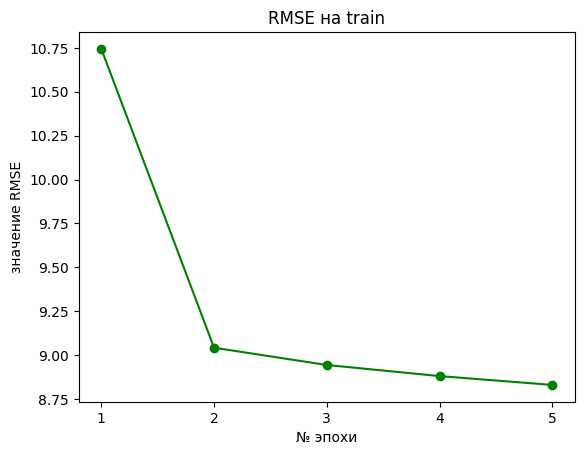

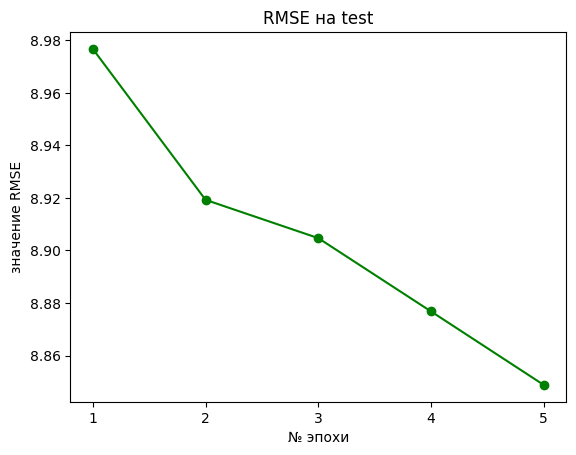

In [37]:
train_set = myDataset(torch.Tensor(X_train), torch.Tensor(y_train_norm))
train_loader = torch.utils.data.DataLoader(train_set, batch_size=128)

test_set = myDataset(torch.Tensor(X_test), torch.Tensor(y_test_norm))
test_loader = torch.utils.data.DataLoader(test_set, batch_size=128)

set_random_seed(42)
model = nn.Sequential(nn.Linear(X_train.shape[1], 61), nn.ReLU(),
                      nn.Linear(61, 42), nn.ReLU(),
                      nn.Linear(42, 29), nn.ReLU(),
                      nn.Linear(29, 20), nn.ReLU(),
                      nn.Linear(20, 1), nn.ReLU())
model.to(device)
optimizer = torch.optim.Adam(model.parameters())
criterion_train = RMSELoss()
criterion_test = nn.MSELoss()

n_epochs = 5

train_losses = []
test_losses = []
for epoch in range(n_epochs):
    train_losses.append(
        train(model, optimizer, criterion_train, train_loader))
    test_losses.append(test(model, criterion_test, test_loader))


plt.plot(np.arange(1, n_epochs+1), train_losses, marker='o', c='g')
plt.title('RMSE на train')
plt.xticks(np.arange(1, n_epochs+1, 1.0))
plt.xlabel('№ эпохи')
plt.ylabel('значение RMSE')
plt.show()

plt.plot(np.arange(1, n_epochs+1), test_losses, marker='o', c='g')
plt.title('RMSE на test')
plt.xticks(np.arange(1, n_epochs+1, 1.0))
plt.xlabel('№ эпохи')
plt.ylabel('значение RMSE')
plt.show()